In [1]:
#1. Gerekli Kütüphanelerin yüklenmesi
%pip install numpy pandas matplotlib scikit-learn seaborn xgboost openpyxl streamlit tensorflow opencv-python 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,UpSampling2D, Conv2DTranspose
from tensorflow.keras.utils import to_categorical
import warnings
import os
from scipy.io import loadmat
import glob
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


     |████████████████████████████████| 72 kB 919 kB/s eta 0:00:011
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#2.#Veri Setinin İndirilmesi
%pip install datasets

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
#3.  Veri setini yükleyelim
from datasets import load_dataset
ds= load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation")

# Dataset içeriğini kontrol edelim
print(ds)

/Users/eceguney/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 1502
    })
    test: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 215
    })
    valid: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 429
    })
})


In [4]:
4. # Veri setindeki örnekleri görüntüleme
print(ds['train'][0])

# Veri örneğinin anahtarlarını inceleme
print(ds['train'][0].keys())

{'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x328FBC850>, 'id': 0, 'category_id': 1, 'bbox': [145.0, 239.0, 168.75, 162.5], 'segmentation': [[313.75, 238.75, 145.0, 238.75, 145.0, 401.25, 313.75, 401.25, 313.75, 238.75]], 'area': 27421.875, 'iscrowd': 0, 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00', 'license': 1}
dict_keys(['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'])


In [5]:
#5. Veri Setini İncelemek:

# Eğitim verisinin ilk örneğini inceleyelim
example = ds['train'][0]
image = example['image']
segmentation = example['segmentation']

# Görüntüleri ve maskeleri kontrol edelim
print(image)
print(segmentation)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x328CD12B0>
[[313.75, 238.75, 145.0, 238.75, 145.0, 401.25, 313.75, 401.25, 313.75, 238.75]]


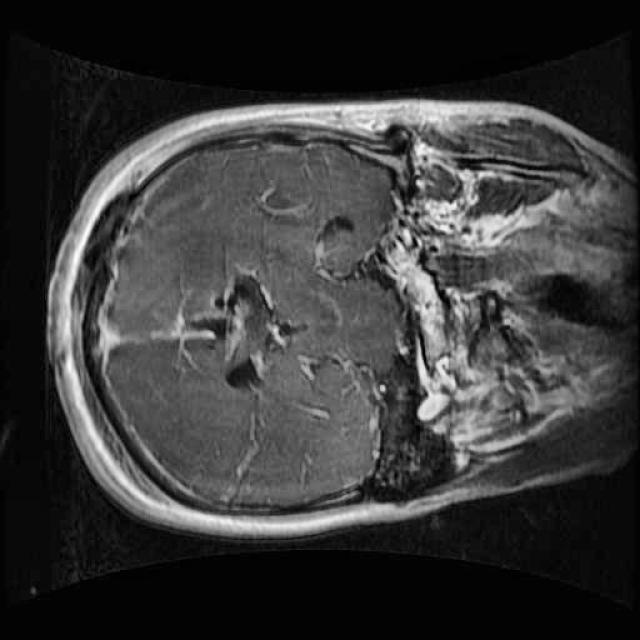

In [6]:
#6.Örnek görüntüyü yükleme
image = ds['train'][0]['image']
image

In [7]:
# 7. Segmentasyon maskesini yükleme
segmentation = ds['train'][0]['segmentation']
segmentation

[[313.75,
  238.75,
  145.0,
  238.75,
  145.0,
  401.25,
  313.75,
  401.25,
  313.75,
  238.75]]

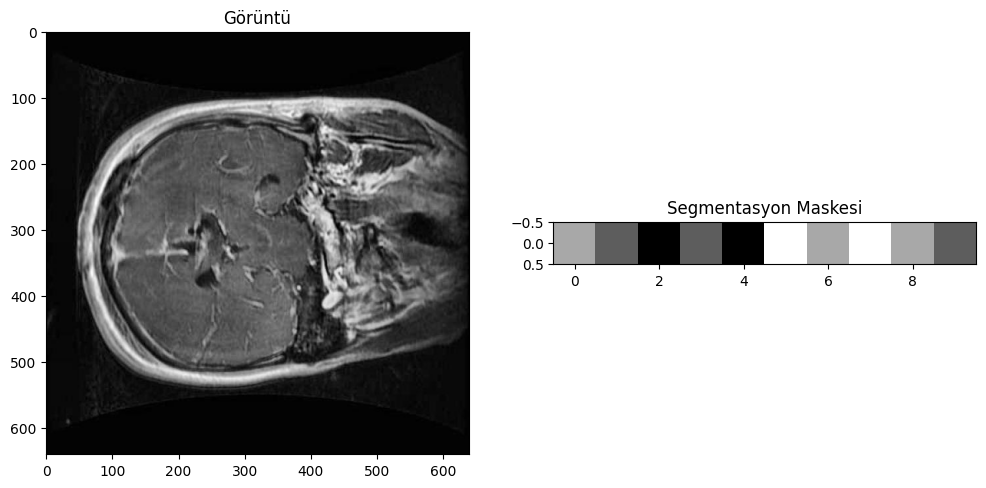

In [8]:
# 8. Görüntüyü ve segmentasyon maskesini görselleştirme
#Segmentasyon görüntünün  belirli bölgelerine veya nesnelere ayırma işlemi olarak tanımlanır.

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Görüntü')

plt.subplot(1, 2, 2)
plt.imshow(segmentation, cmap='gray')
plt.title('Segmentasyon Maskesi')

plt.show()

In [9]:
#9. Klasördeki Tüm .mat Dosyalarını Listeleme

# .mat dosyasını yükle, klasördeki tüm .mat dosyalarını bul 
folder_path="/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data"
mat_files = glob.glob(os.path.join(folder_path, "*.mat"))

# Bulunan dosyaları yazdır
print("Bulunan .mat dosyaları:")
print(mat_files)

Bulunan .mat dosyaları:
['/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/259.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/1915.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/1901.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/265.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/1929.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/1097.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/503.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/517.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/1083.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/271.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/2207.mat', '/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/2561.ma

In [10]:
# 10. Veri artırma örneği
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)


# Klasördeki tüm .mat dosyalarını listele
folder_path = "/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data"  # Klasör yolunu buraya yazın
mat_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

# Her dosyayı okuma ve işleme
for mat_file in mat_files:
    file_path = os.path.join(folder_path, mat_file)
    
    # Dosyayı yükle
    with h5py.File(file_path, 'r') as data:
        print(f"İşlenen dosya: {mat_file}")
        print(f"Anahtarlar: {list(data.keys())}")
        
        # Görüntü değişkenini kontrol et (örneğin 'image' adlı değişken)
        if 'image' in data:
            # Görüntüyü yükle
            image = np.array(data['image'])
            
            # Görüntüyü normalize et (0-255 arası değerlere)
            image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
            image_normalized = image_normalized.astype(np.uint8)
            
            # Görüntüyü görselleştir
            plt.imshow(image_normalized, cmap='gray')
            plt.title(f"Görüntü: {mat_file}")
            plt.show()
            
            # Görüntüyü kaydetmek isterseniz
            output_folder = "çıkış_klasörü"  # Çıkış klasörünü belirleyin
            os.makedirs(output_folder, exist_ok=True)
            output_path = os.path.join(output_folder, mat_file.replace('.mat', '.png'))
            Image.fromarray(image_normalized).save(output_path)
            
            print(f"Görüntü {output_path} olarak kaydedildi.")
        else:
            print(f"{mat_file} dosyasında 'image' anahtarı bulunamadı.")

İşlenen dosya: 259.mat
Anahtarlar: ['cjdata']
259.mat dosyasında 'image' anahtarı bulunamadı.
İşlenen dosya: 1915.mat
Anahtarlar: ['cjdata']
1915.mat dosyasında 'image' anahtarı bulunamadı.
İşlenen dosya: 1901.mat
Anahtarlar: ['cjdata']
1901.mat dosyasında 'image' anahtarı bulunamadı.
İşlenen dosya: 265.mat
Anahtarlar: ['cjdata']
265.mat dosyasında 'image' anahtarı bulunamadı.
İşlenen dosya: 1929.mat
Anahtarlar: ['cjdata']
1929.mat dosyasında 'image' anahtarı bulunamadı.
İşlenen dosya: 1097.mat
Anahtarlar: ['cjdata']
1097.mat dosyasında 'image' anahtarı bulunamadı.
İşlenen dosya: 503.mat
Anahtarlar: ['cjdata']
503.mat dosyasında 'image' anahtarı bulunamadı.
İşlenen dosya: 517.mat
Anahtarlar: ['cjdata']
517.mat dosyasında 'image' anahtarı bulunamadı.
İşlenen dosya: 1083.mat
Anahtarlar: ['cjdata']
1083.mat dosyasında 'image' anahtarı bulunamadı.
İşlenen dosya: 271.mat
Anahtarlar: ['cjdata']
271.mat dosyasında 'image' anahtarı bulunamadı.
İşlenen dosya: 2207.mat
Anahtarlar: ['cjdata']
220

In [11]:
#11.mat (MATLAB verisi) uzantılı bir dosyayı Python'da h5py kütüphanesiyle okumak için kullanılıyor. 
file_path = "/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/259.mat"

with h5py.File(file_path, 'r') as data:
    print(f"Anahtarlar: {list(data.keys())}")

# 'cjdata' anahtarını kontrol et
    cjdata = data['cjdata']
    print(f"'cjdata' veri türü: {type(cjdata)}")

    # Eğer bir grupsa, içeriğini listele
    if isinstance(cjdata, h5py.Group):
        print(f"'cjdata' alt anahtarlar: {list(cjdata.keys())}")
    else:
        print(f"'cjdata' içeriği: {cjdata}")

Anahtarlar: ['cjdata']
'cjdata' veri türü: <class 'h5py._hl.group.Group'>
'cjdata' alt anahtarlar: ['PID', 'image', 'label', 'tumorBorder', 'tumorMask']


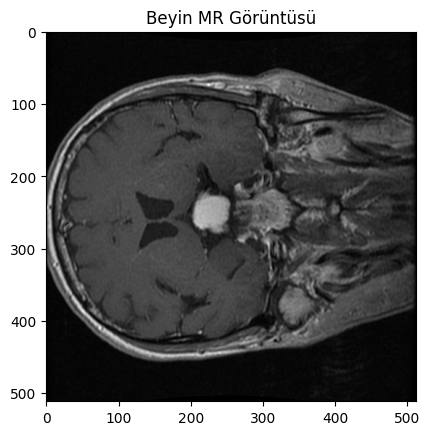

Etiket (label): [[1.]]


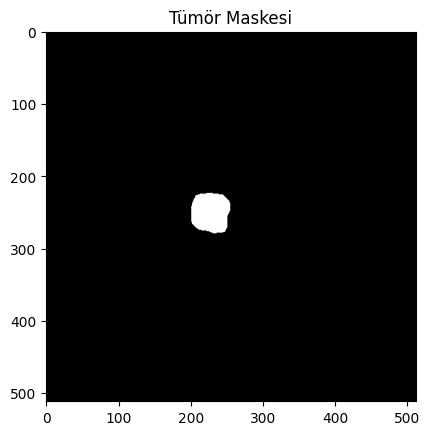

In [12]:
#12. #Veriyi Okuma ve Görselleştirme
file_path = "/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/259.mat"

with h5py.File(file_path, 'r') as data:
    cjdata = data['cjdata']

    # Görüntüyü yükleme
    image = np.array(cjdata['image'])
    plt.imshow(image, cmap='gray')
    plt.title("Beyin MR Görüntüsü")
    plt.show()

    # Etiketi kontrol etme
    label = np.array(cjdata['label'])
    print(f"Etiket (label): {label}")

    # Tümör maskesini görselleştirme
    tumor_mask = np.array(cjdata['tumorMask'])
    if tumor_mask.any():  # Eğer maske boş değilse
        plt.imshow(tumor_mask, cmap='gray')
        plt.title("Tümör Maskesi")
        plt.show()

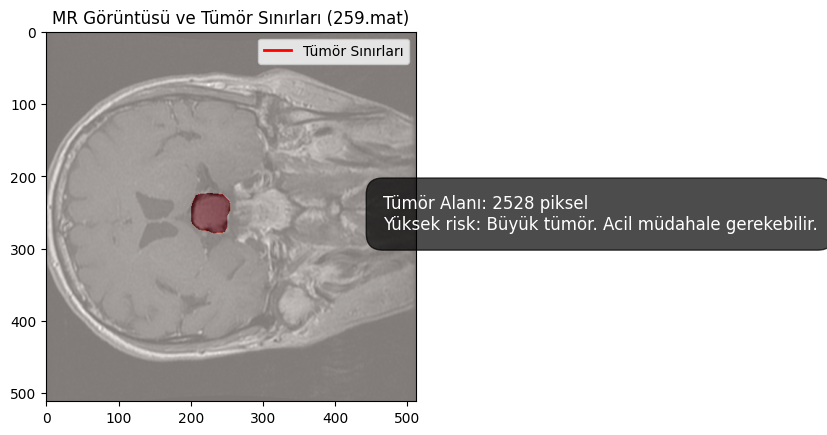

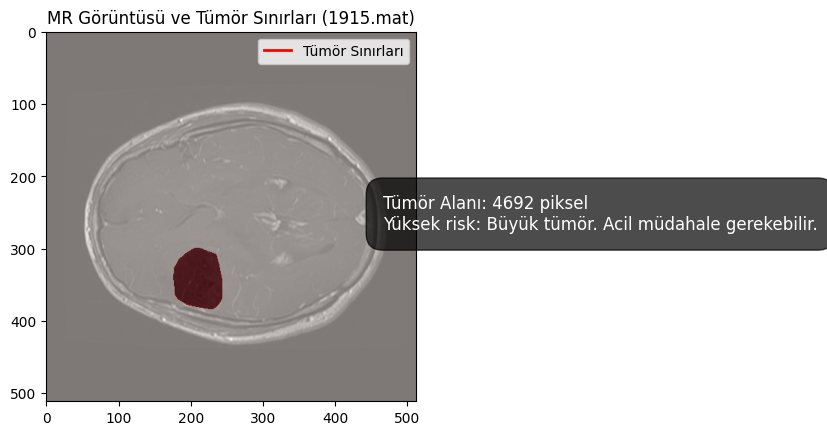

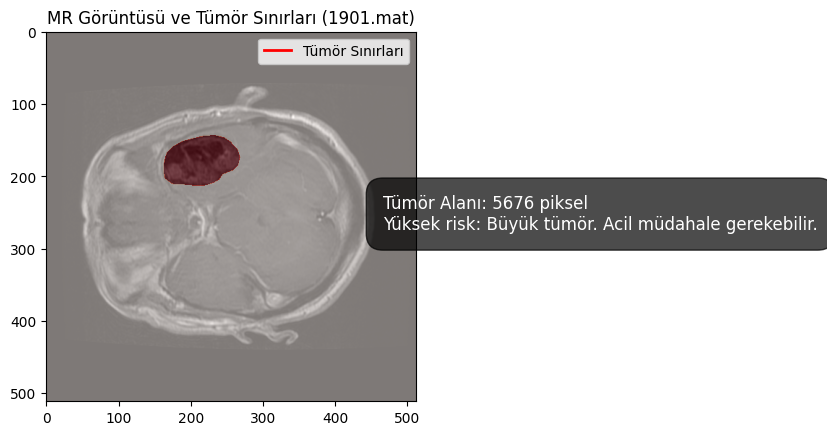

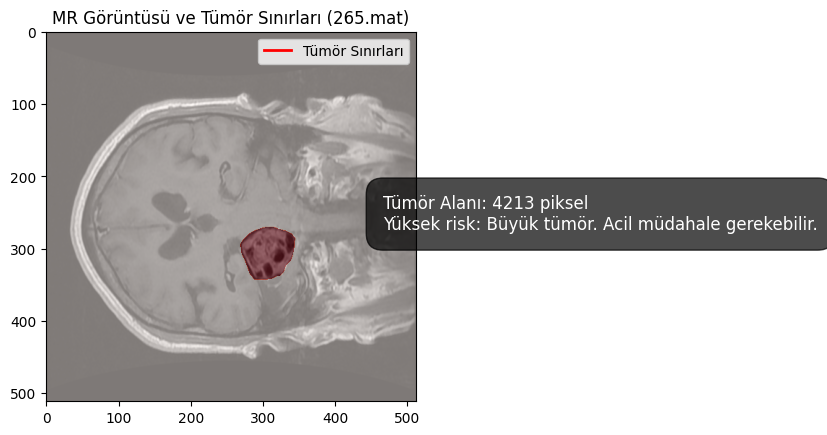

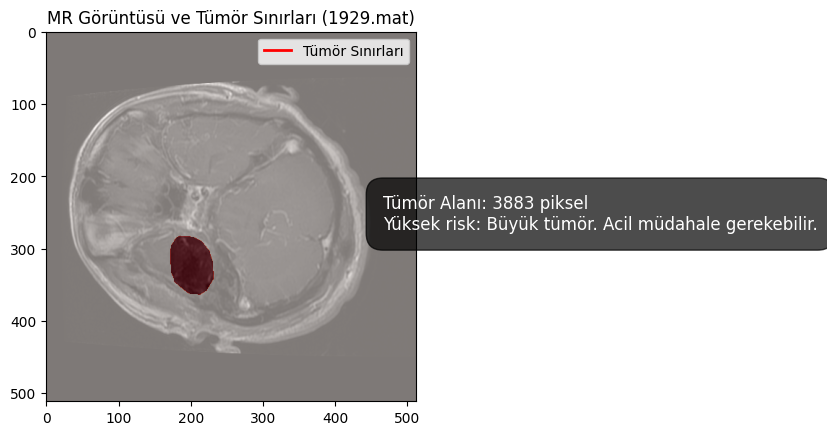

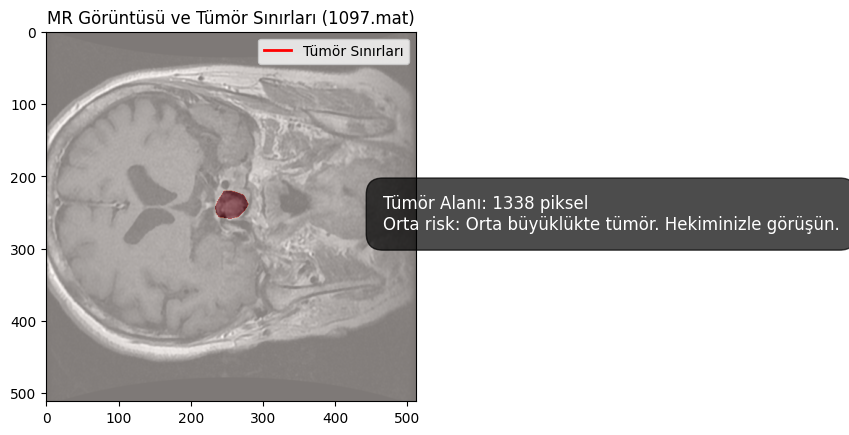

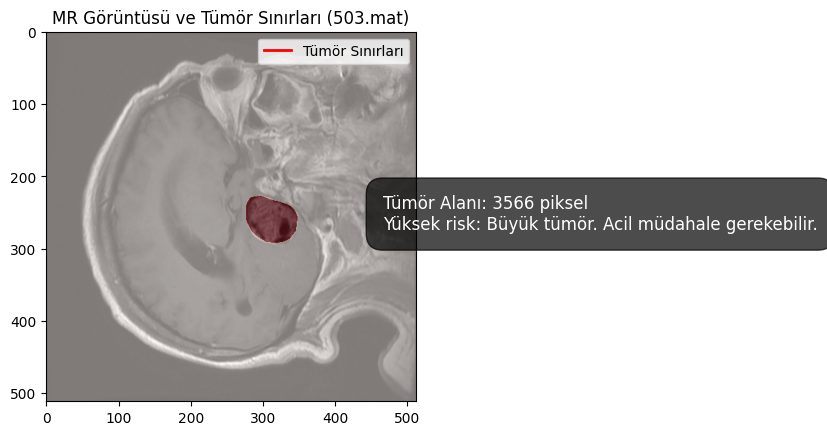

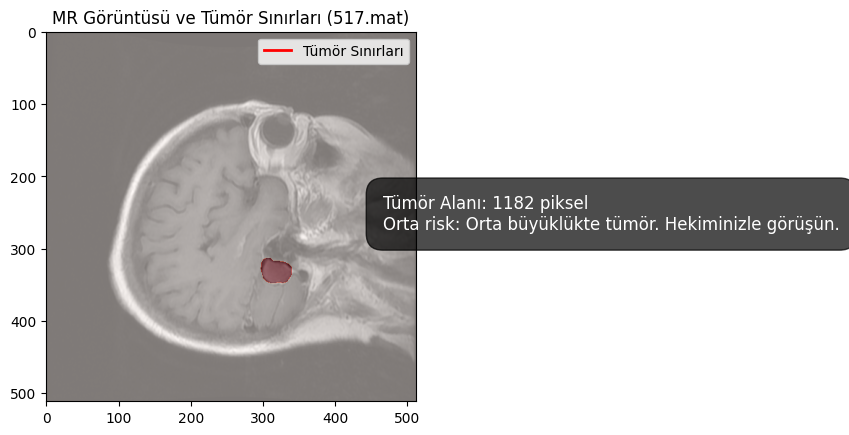

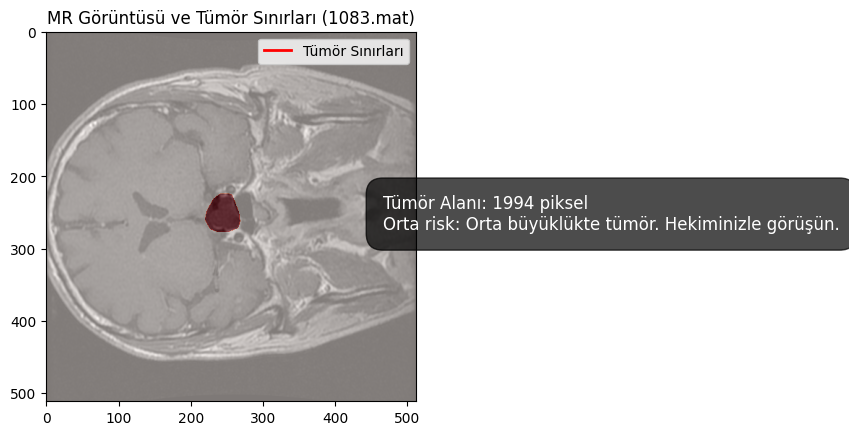

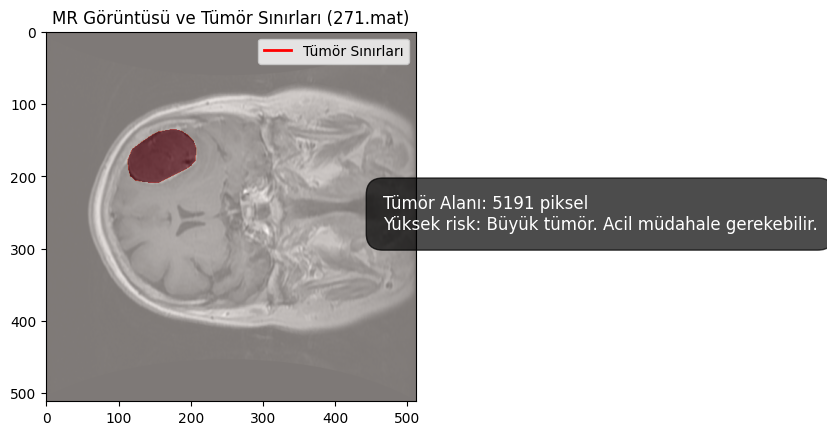

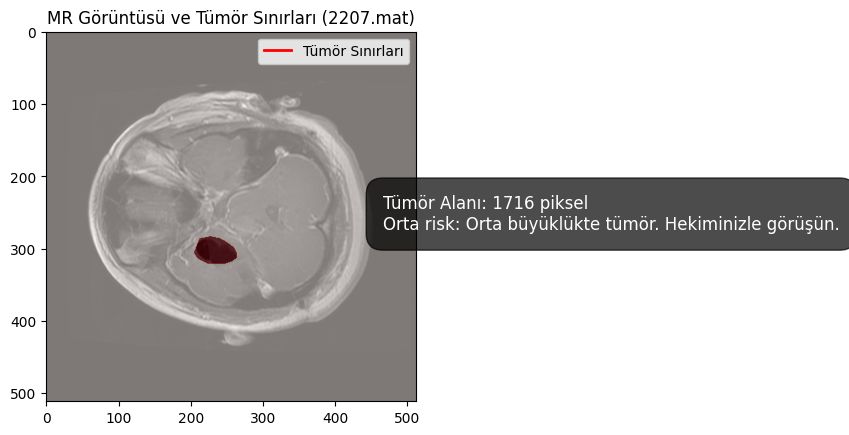

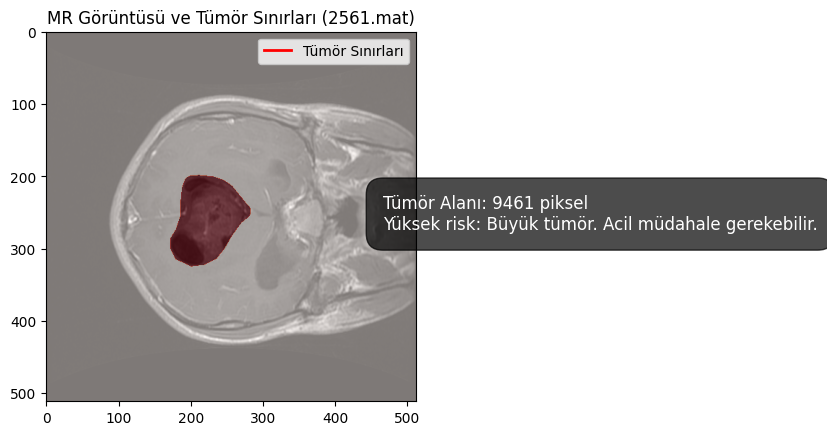

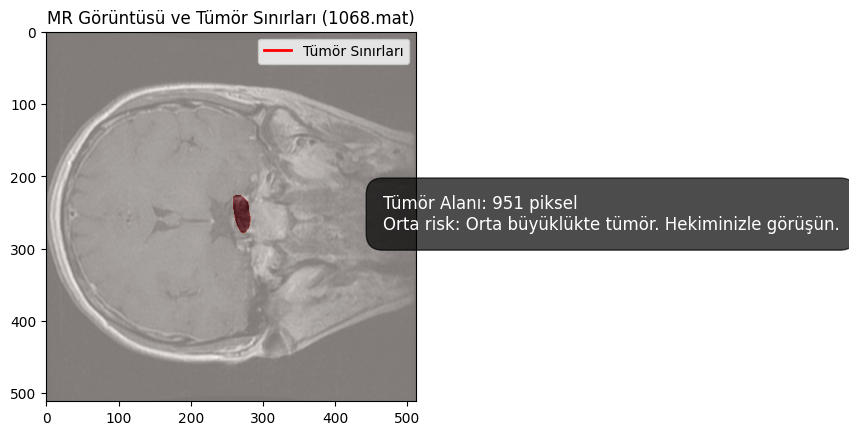

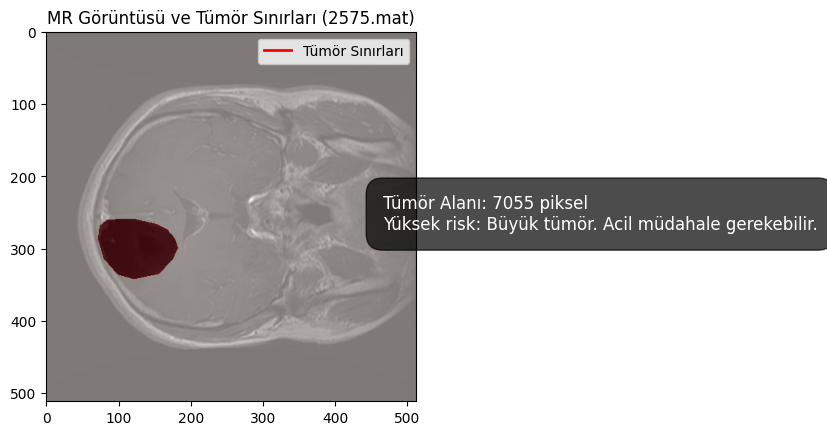

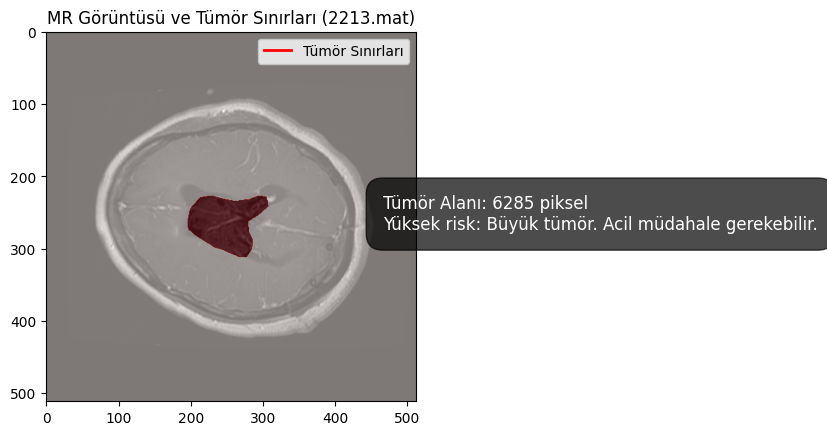

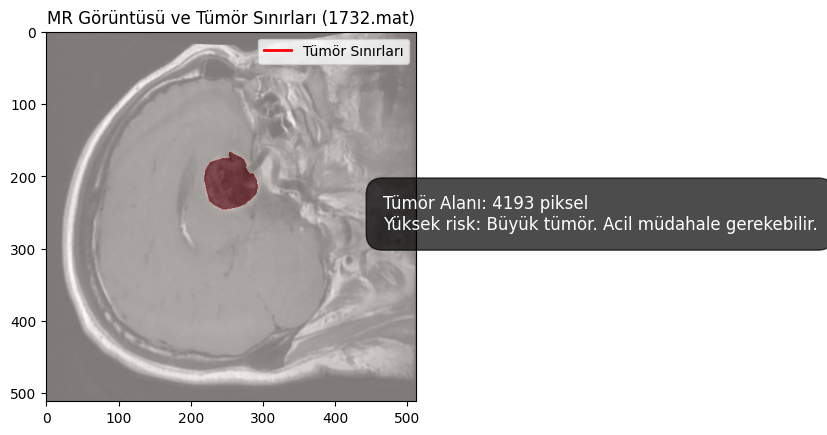

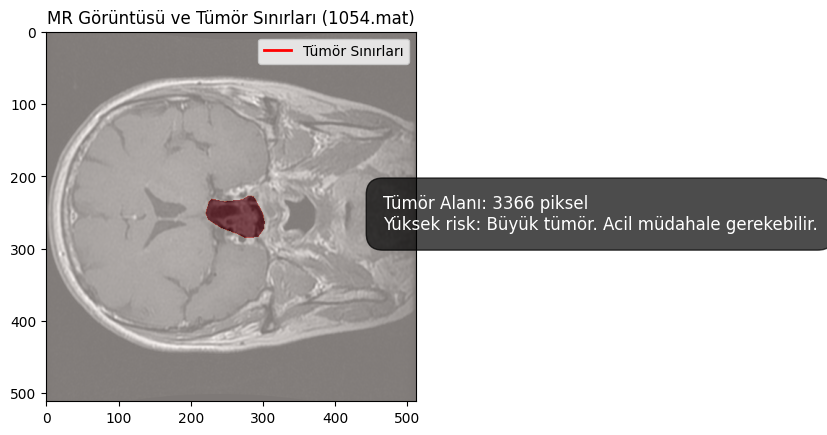

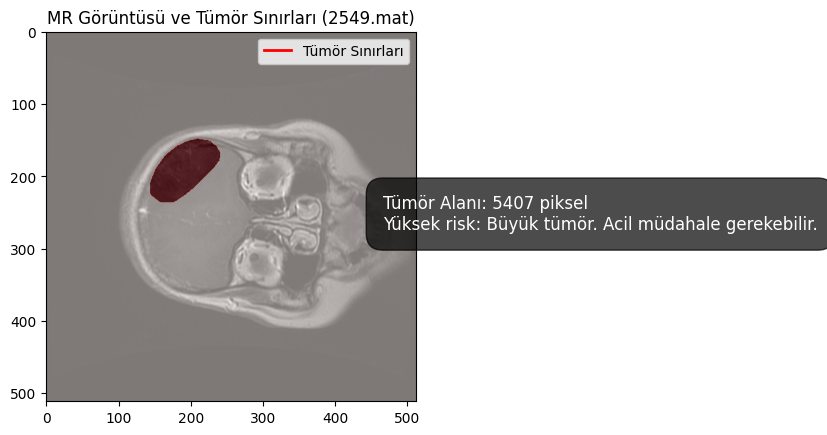

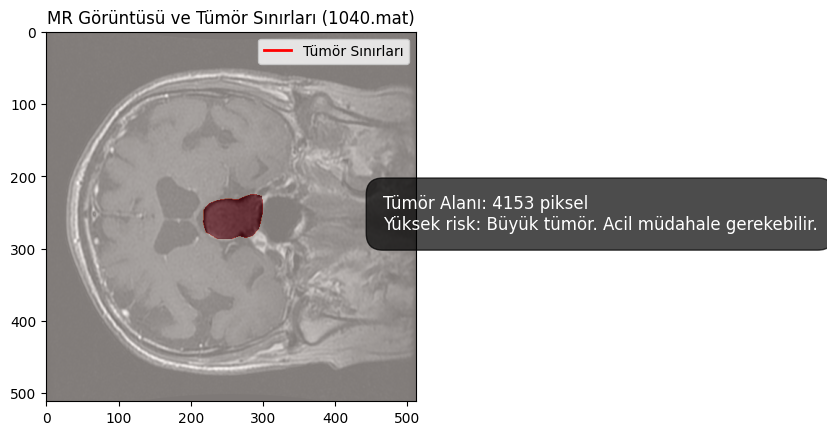

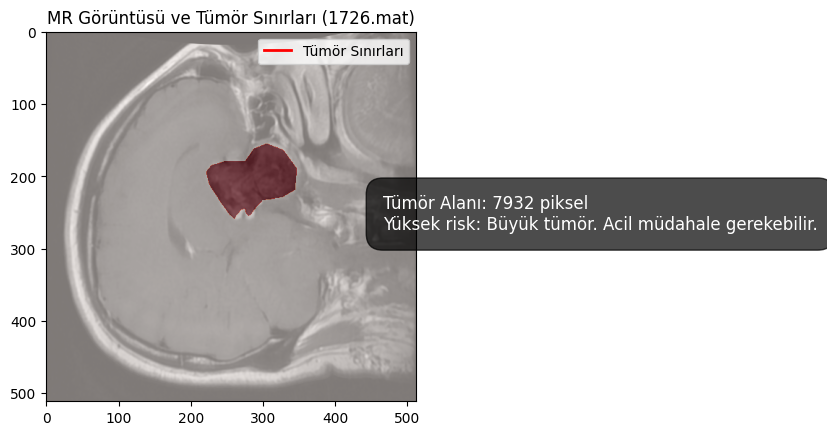

Tümör Bulunan Görüntüler: 20
Tümör Olmayan Görüntüler: 0


In [13]:
#13.mat dosyalarının bulunduğu dizin
folder_path = "/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/"

# Dizin içindeki .mat dosyalarını listeleme
mat_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

# İlk 20 görüntü ile sınırlama
mat_files = mat_files[:20]

# Görüntülerde tümör olup olmadığını kontrol etmek için bir sayaç
tumor_found_count = 0
non_tumor_count = 0

# Her bir .mat dosyasını işlemek için döngü
for mat_file in mat_files:
    file_path = os.path.join(folder_path, mat_file)
    
    # Dosyayı açma
    with h5py.File(file_path, 'r') as data:
        cjdata = data['cjdata']
        
        # Görüntü verisini alma
        image = np.array(cjdata['image'])  # Görüntü

        # 'tumorBorder' verisini alma
        tumor_border = None
        if 'tumorBorder' in cjdata:
            tumor_border = np.array(cjdata['tumorBorder'])
            tumor_found_count += 1  # Tümör bulunan görüntü sayısını artır

        # 'tumorMask' verisini alma (Tümör maskesi var mı?)
        tumor_mask = None
        if 'tumorMask' in cjdata:
            tumor_mask = np.array(cjdata['tumorMask'])

        # Görüntüyü siyah-beyaz (gri tonlarında) olarak gösterme
        plt.imshow(image, cmap='gray')  # Siyah-beyaz görüntü

        # Eğer tümör sınırı varsa, bunu kırmızı renkte çizme
        if tumor_border is not None:
            plt.plot(tumor_border[:, 0], tumor_border[:, 1], color='red', label="Tümör Sınırları", linewidth=2)
        else:
            non_tumor_count += 1  # Tümör olmayan görüntü sayısını artır

        # Maskeyi kırmızı olarak ekleme (şeffaflık ile)
        if tumor_mask is not None:
            plt.imshow(tumor_mask, cmap='Reds', alpha=0.5)  # Kırmızı tonlarında ve şeffaf olarak eklenmiş

            # Tümörün boyutunu hesaplama (maskedeki piksel sayısı)
            tumor_area = np.sum(tumor_mask)  # Tümör maskesindeki beyaz piksel sayısı (tümör alanı)
            
            # Risk analizi
            if tumor_area < 500:
                risk_message = "Düşük risk: Küçük tümör. Düzenli takip gereklidir."
            elif tumor_area < 2000:
                risk_message = "Orta risk: Orta büyüklükte tümör. Hekiminizle görüşün."
            else:
                risk_message = "Yüksek risk: Büyük tümör. Acil müdahale gerekebilir."

            # Mesaj kutusunda tümör durumu ve risk bilgisini gösterme
            message = f"Tümör Alanı: {tumor_area} piksel\n{risk_message}"
        else:
            # Tümör bulunmayan görüntüler için mesaj
            message = "Tümör bulunmamaktadır.\nSağlıklı günler dileriz."
        
        # Başlık ve etiket ekleme
        plt.title(f"MR Görüntüsü ve Tümör Sınırları ({mat_file})")
        plt.legend()

        # Görüntüde mesaj kutusunu ekleme (sayfanın sağ kısmına siyah kutu, beyaz yazı)
        plt.figtext(0.75, 0.5, message, fontsize=12, color='white', ha='left', va='center',
                    bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=1'))

        # Görüntüyü gösterme
        plt.show()

# Sonuçları yazdırma
print(f"Tümör Bulunan Görüntüler: {tumor_found_count}")
print(f"Tümör Olmayan Görüntüler: {non_tumor_count}")


In [14]:
#14.  Verinin bulunduğu dizin (sizin veri setinizin yolu)
folder_path = "/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/dataset/data/"

# Dizin içindeki .mat dosyalarını listeleme
mat_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

# İlk 20 görüntü ile sınırlama
mat_files = mat_files[:20]

# Görüntülerde tümör olup olmadığını kontrol etmek için sayaçlar
tumor_found_count = 0
non_tumor_count = 0

# Görüntüleri ve segmentasyonları yüklemek için boş listeler
images = []
segmentations = []

# Her bir .mat dosyasını işlemek için döngü
for mat_file in mat_files:
    file_path = os.path.join(folder_path, mat_file)
    
    # Dosyayı açma
    with h5py.File(file_path, 'r') as data:
        cjdata = data['cjdata']
        
        # Görüntü verisini alma
        image = np.array(cjdata['image'])  # Görüntü
        
        # 'tumorMask' verisini alma (Tümör maskesi var mı?)
        tumor_mask = None
        if 'tumorMask' in cjdata:
            tumor_mask = np.array(cjdata['tumorMask'])
            tumor_found_count += 1  # Tümör bulunan görüntü sayısını artır
        else:
            non_tumor_count += 1  # Tümör olmayan görüntü sayısını artır

        # Görüntüyü siyah-beyaz (gri tonlarında) olarak işleme
        preprocessed_image = cv2.resize(image, (128, 128))  # Boyutlandırma
        preprocessed_image = img_to_array(preprocessed_image) / 255.0  # Normalizasyon
        
        # Segmentasyon maskesini de aynı boyutlarda işleme
        if tumor_mask is not None:
            preprocessed_segmentation = cv2.resize(tumor_mask, (128, 128))
            preprocessed_segmentation = preprocessed_segmentation.astype(np.float32)
        else:
            preprocessed_segmentation = np.zeros((128, 128), dtype=np.float32)  # Tümör yoksa boş maske

        # Görüntü ve maskeyi listelere ekleyelim
        images.append(preprocessed_image)
        segmentations.append(preprocessed_segmentation)

# Görüntüleri ve segmentasyonları NumPy dizilerine dönüştürme
images = np.array(images)
segmentations = np.array(segmentations)

# Modelin eğitimi için verileri hazırlama
images = images[..., np.newaxis]  # Siyah-beyaz (tek kanal) görüntüler için boyut ekleme
segmentations = segmentations[..., np.newaxis]  # Maskeler de tek kanal olacak

# Modelin oluşturulması (UNet tarzı bir model kullanılabilir)
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(128, 128, 1)))  # 128x128 boyutunda gri tonlama görüntü
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))  # Segmentasyon için son katman

from sklearn.model_selection import train_test_split

# Verilerinizi (images ve segmentations) eğitim ve test verisi olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(images, segmentations, test_size=0.2, random_state=42)

# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğitme
model.fit(X_train, y_train, epochs=5, batch_size=1)

# Modelin özetini görüntüleme
model.summary()

# Modelin test veri seti üzerindeki başarımını değerlendirme
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

# Test doğruluğunu yazdırma
print(f"Test doğruluğu: {test_acc:.4f}")


Epoch 1/5


/Users/eceguney/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8898 - loss: 0.3809
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9833 - loss: 0.1539
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9857 - loss: 0.0983
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9823 - loss: 0.0809
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9841 - loss: 0.0603


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 998,405 (3.81 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 665,604 (2.54 MB)

1/1 - 0s - 159ms/step - accuracy: 0.9833 - loss: 0.0904
Test doğruluğu: 0.9833


In [15]:
#Projeyi VsCode Terminaline Streamlitte Yayınlama Kodu  Gir 
# streamlit run "/Users/eceguney/Desktop/veri bilimi/kod calismalarim/mri/tumor_detection_app.py" 

In [16]:
#Projeye Aşağıdaki linkten Ulaşabilirsiniz

 #Local URL: http://localhost:8502
 #Network URL: http://192.168.31.243:8502